In [1]:
import os.path as osp

In [2]:
from torch_geometric.data     import DataLoader
from torch_geometric.datasets import TUDataset, PPI
from torch_geometric.nn       import TopKPooling, GCNConv, GINConv, SAGPooling
import torch.nn.functional        as F
import torch_geometric.transforms as T
import torch
from torch_geometric.nn      import global_max_pool
from torch_scatter           import scatter_mean
from torch.nn import Sequential as Seq, Linear as Lin, ReLU

In [25]:
%pylab inline
from sklearn.manifold import TSNE
import operator
from functools import reduce

Populating the interactive namespace from numpy and matplotlib


In [26]:
class HandleNodeAttention(object):
    def __call__(self, data):
        data.attn = torch.softmax(data.x, dim=0)
        data.x = None
        return data

transform = T.Compose([HandleNodeAttention(), T.OneHotDegree(max_degree=14)])
path = osp.join(osp.abspath(''), '..', 'data', 'TRIANGLES')
dataset = TUDataset(path, name='FIRSTMM_DB', use_node_attr=True, transform=transform)

train_loader = DataLoader(dataset[:30000], batch_size=5, shuffle=True)

# path = osp.join(osp.abspath(''), '..', 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset   = PPI(path, split='val')
# test_dataset  = PPI(path, split='test')
# train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader    = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader   = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [51]:
# class Net(torch.nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = GCNConv(test_dataset.num_features, 64)
#         self.topk_pool = TopKPooling(in_channels=64)
#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch
        
#         x = F.relu(self.conv1(x, edge_index))
#         x, edge_index, _, batch, perm, score = self.topk_pool(x, edge_index, None, batch)
        
#         return x, edge_index
import networkx          as nx
import matplotlib.pyplot as plt
options = {
    'node_color': 'black',
    'node_size': 100,
    'width': 3,
}
class Net(torch.nn.Module):
    def __init__(self, in_channels):
        super(Net, self).__init__()

        self.conv1 = GINConv(Seq(Lin(in_channels, 64), ReLU(), Lin(64, 64)))
#         self.pool1s = SAGPooling(64, min_score=0.001, GNN=GCNConv)
#         self.pool1t = TopKPooling(64,min_score=0.001)
        self.pool1s = SAGPooling(64, ratio=0.5, GNN=GCNConv)
        self.pool1t = TopKPooling(64,ratio=0.5)
        self.conv2 = GINConv(Seq(Lin(64, 64), ReLU(), Lin(64, 64)))
        self.pool2s = SAGPooling(64, ratio=0.5, GNN=GCNConv)
        self.pool2t = TopKPooling(64, ratio=0.5)
        self.conv3 = GINConv(Seq(Lin(64, 64), ReLU(), Lin(64, 64)))

        self.lin = torch.nn.Linear(64, 1)
        self.i = 0

    def forward(self, data):
        self.i += 1
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if self.i == 200 :
            origin_graph = nx.Graph()
    #         print(edge_index.cpu().numpy().tolist())
            edges = edge_index.cpu().numpy().tolist()
            origin_graph.add_edges_from(zip(edges[0],edges[1]))
    #         nx.draw_spectral(origin_graph, **options)
    #         plt.savefig("./origin_graphr"+str(self.i)+".png")
            nx.readwrite.graphml.write_graphml(origin_graph, "./origin_graphr"+str(self.i)+".graphml")

    #         x_tsne = TSNE(learning_rate=100).fit_transform(x.cpu().numpy())
            x_tsne = TSNE(n_components=2, perplexity=5, verbose=2).fit_transform(x.cpu().numpy())
            figure(figsize=(10, 5))
#             scatter(x_tsne[:, 0], x_tsne[:, 1], c=batch.cpu().numpy())
#             print(data.y.cpu().numpy())
#             print(batch.cpu().numpy())
            label = [ data.y.cpu().numpy()[i] for i in batch.cpu().numpy()]
#             print(label)
            scatter(x_tsne[:, 0], x_tsne[:, 1], c=label)#, cmap=plt.get_cmap("gist_rainbow"), colorbar=True)
#             scatter(x_tsne[:, 0], x_tsne[:, 1], c=reduce(operator.add, data.y.cpu().numpy()))
            plt.savefig("./origin_graph_tsne"+str(self.i)+".png")
        
        x = F.relu(self.conv1(x, edge_index))
        x_t, edge_index_t, _, batch_t, perm_t, score_t = self.pool1t(x, edge_index, None, batch)
        x, edge_index, _, batch, perm, score = self.pool1s(x, edge_index, None, batch)
        if self.i == 200 :
            topk1_graph = nx.Graph()
            sag1__graph = nx.Graph()

            edges = edge_index_t.cpu().numpy().tolist()
            topk1_graph.add_edges_from(zip(edges[0],edges[1]))
    #         nx.draw_spectral(topk1_graph, **options)
    #         plt.savefig("./topk1_graph"+str(self.i)+".png")
    #         nx.readwrite.graphml.write_graphml(topk1_graph, "./topk1_graph"+str(self.i)+".graphml")
    #         x_tsne = TSNE(learning_rate=100).fit_transform(x_t.cpu().detach().numpy())
            x_tsne = TSNE(n_components=2, perplexity=5, verbose=2).fit_transform(x_t.cpu().detach().numpy())
            figure(figsize=(10, 5))
            label = [ data.y.cpu().numpy()[i] for i in batch_t.cpu().numpy()]
            scatter(x_tsne[:, 0], x_tsne[:, 1], c=label)
            plt.savefig("./topk1_graph_tsne"+str(self.i)+".png")

            edges = edge_index.cpu().numpy().tolist()
            sag1__graph.add_edges_from(zip(edges[0],edges[1]))
    #         nx.draw_spectral(sag1__graph, **options)
    #         plt.savefig("./sag1__graph"+str(self.i)+".png")
    #         nx.readwrite.graphml.write_graphml(sag1__graph, "./sag1__graph"+str(self.i)+".graphml")
    #         x_tsne = TSNE(learning_rate=100).fit_transform(x.cpu().detach().numpy())
            x_tsne = TSNE(n_components=2, perplexity=5, verbose=2).fit_transform(x.cpu().detach().numpy())
            figure(figsize=(10, 5))
            label = [ data.y.cpu().numpy()[i] for i in batch.cpu().numpy()]
            scatter(x_tsne[:, 0], x_tsne[:, 1], c=label)
            plt.savefig("./sag1_graph_tsne"+str(self.i)+".png")
        
        x = F.relu(self.conv2(x, edge_index))
        
        x_t, edge_index_t, _, batch_t, perm_t, score_t = self.pool2t(x, edge_index, None, batch)
        x,   edge_index,   _, batch,   perm,   score   = self.pool2s(x, edge_index, None, batch)
        if self.i == 200 :
            topk2_graph = nx.Graph()
            sag2__graph = nx.Graph()
            edges = edge_index_t.cpu().numpy().tolist()
            topk2_graph.add_edges_from(zip(edges[0],edges[1]))
    #         nx.draw_spectral(topk2_graph, **options)
    #         plt.savefig("./topk2_graph"+str(self.i)+".png")
    #         nx.readwrite.graphml.write_graphml(topk2_graph, "./topk2_graph"+str(self.i)+".graphml")
    #         x_tsne = TSNE(learning_rate=100).fit_transform(x_t.cpu().detach().numpy())
            x_tsne = TSNE(n_components=2, perplexity=5, verbose=2).fit_transform(x_t.cpu().detach().numpy())
            figure(figsize=(10, 5))
            label = [ data.y.cpu().numpy()[i] for i in batch_t.cpu().numpy()]
            scatter(x_tsne[:, 0], x_tsne[:, 1], c=label)
            plt.savefig("./topk2_graph_tsne"+str(self.i)+".png")

            edges = edge_index.cpu().numpy().tolist()
            sag2__graph.add_edges_from(zip(edges[0],edges[1]))
    #         nx.draw_spectral(sag2__graph, **options)
    #         plt.savefig("./sag2__graph"+str(self.i)+".png")
    #         nx.readwrite.graphml.write_graphml(sag2__graph, "./sag2__graph"+str(self.i)+".graphml")
    #         x_tsne = TSNE(learning_rate=100).fit_transform(x.cpu().detach().numpy())
            x_tsne = TSNE(n_components=2, perplexity=5, verbose=2).fit_transform(x.cpu().detach().numpy())
            figure(figsize=(10, 5))
            label = [ data.y.cpu().numpy()[i] for i in batch.cpu().numpy()]
            scatter(x_tsne[:, 0], x_tsne[:, 1], c=label)
            plt.savefig("./sag2_graph_tsne"+str(self.i)+".png")
        
        ratio = x.size(0) / data.x.size(0)

        x = F.relu(self.conv3(x, edge_index))
        x = global_max_pool(x, batch)
        x = self.lin(x).view(-1)

        attn_loss = F.kl_div(torch.log(score + 1e-14), data.attn[perm], reduction='none')
        attn_loss = scatter_mean(attn_loss, batch)

        return x, attn_loss, ratio

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 93 samples in 0.009s...
[t-SNE] Computed neighbors for 93 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 93 / 93
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 53.2924995, gradient norm = 0.4825704 (50 iterations in 0.027s)
[t-SNE] Iteration 100: error = 49.0542030, gradient norm = 0.5562780 (50 iterations in 0.025s)
[t-SNE] Iteration 150: error = 50.2392502, gradient norm = 0.4862048 (50 iterations in 0.026s)
[t-SNE] Iteration 200: error = 48.1945343, gradient norm = 0.4931083 (50 iterations in 0.026s)
[t-SNE] Iteration 250: error = 48.5487595, gradient norm = 0.4682145 (50 iterations in 0.024s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.548759
[t-SNE] Iteration 300: error = 1.0144968, gradient norm = 0.0190361 (50 iterations in 0.025s)
[t-SNE] Iteration 350: error = 0.8198894, gradient norm = 0.0185811 (50 i

[t-SNE] Iteration 650: error = 0.5080002, gradient norm = 0.0000873 (50 iterations in 0.018s)
[t-SNE] Iteration 700: error = 0.4408093, gradient norm = 0.0004000 (50 iterations in 0.015s)
[t-SNE] Iteration 750: error = 0.3271332, gradient norm = 0.0003996 (50 iterations in 0.014s)
[t-SNE] Iteration 800: error = 0.2705354, gradient norm = 0.0002818 (50 iterations in 0.015s)
[t-SNE] Iteration 850: error = 0.2200160, gradient norm = 0.0001637 (50 iterations in 0.015s)
[t-SNE] Iteration 900: error = 0.1808233, gradient norm = 0.0001755 (50 iterations in 0.013s)
[t-SNE] Iteration 950: error = 0.1245456, gradient norm = 0.0001613 (50 iterations in 0.013s)
[t-SNE] Iteration 1000: error = 0.1048267, gradient norm = 0.0001148 (50 iterations in 0.013s)
[t-SNE] KL divergence after 1000 iterations: 0.104827
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 26 samples in 0.017s...
[t-SNE] Computed neighbors for 26 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 26

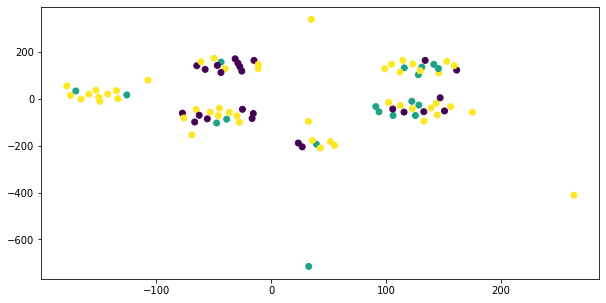

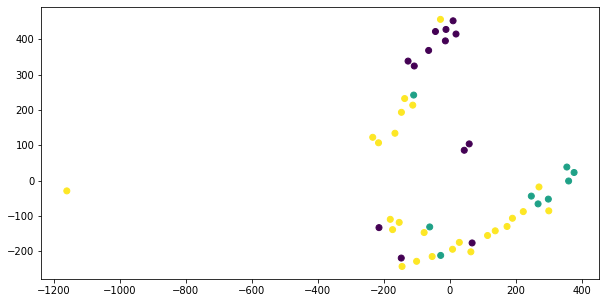

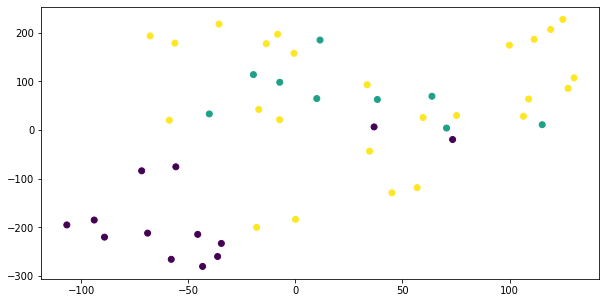

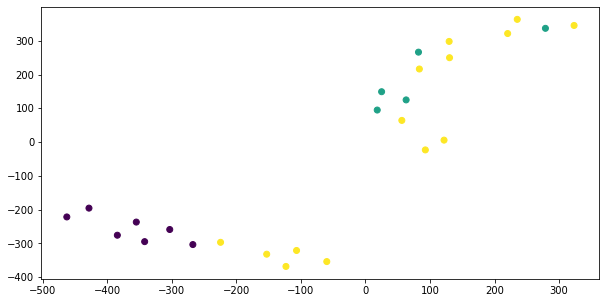

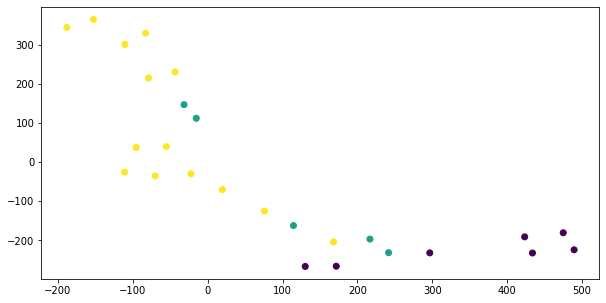

In [53]:
# import networkx as nx
# model.train()
# total_loss = 0
# for data in train_loader:
#     edge_index = data.edge_index
    
#     data = data.to(device)
#     optimizer.zero_grad()
#     out, attn_loss, _ = model(data)
#     loss = ((out - data.y).pow(2) + 100 * attn_loss).mean()
#     loss.backward()
#     total_loss += loss.item() * data.num_graphs
#     optimizer.step()
#     print(total_loss / len(train_loader.dataset))
def train(epoch):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, attn_loss, _ = model(data)
        loss = ((out - data.y).pow(2) + 100 * attn_loss).mean()
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
        return

    return total_loss / len(train_loader.dataset)
for epoch in range(1, 201):
    loss = train(epoch)
#     train_correct, train_ratio = test(train_loader)
#     val_correct, val_ratio = test(val_loader)
#     test_correct, test_ratio = test(test_loader)

#     train_acc = train_correct.sum().item() / train_correct.size(0)
#     val_acc = val_correct.sum().item() / val_correct.size(0)

#     test_acc1 = test_correct[:5000].sum().item() / 5000
#     t.cpu().numpy()est_acc2 = test_correct[5000:].sum().item() / 5000

#     print(('Epoch: {:03d}, Los.cpu().numpy()s: {:.4f}, Train: {:.3f}, Val: {:.3f}, '
#            'Test Orig:.cpu().numpy() {:.3f}, Test Large: {:.3f}, '
#            'Train/Val/Test Ratio={:.3f}/{:.3f}/{:.3f}').format(
#                epoch, loss, train_acc, val_acc, test_acc1, test_acc2,
#                train_ratio, val_ratio, test_ratio))

In [ ]:

G = nx.Graph()
G.add_edges_from([(1,2),(3,4)])

In [ ]:
nx.draw(G, with_labels=True)

In [ ]:

# a = torch.tensor([[7,8],[8,9]])
# a = a.to(torch.device('cuda'))
a = [[7,8],[8,9]]
G = nx.Graph()
# G.add_edges_from(a.numpy())
G.add_edges_from(zip(a[0],a[1]))

In [ ]:
nx.draw(G, with_labels=True)

In [ ]:
torch.cuda.is_available()

In [ ]:
a.numpy()

In [ ]:
b = zip(a[0],a[1])

In [ ]:
print(list(b))